## Modeling
This notebook will use the cleaned data from the web_scrapping and will run it through various linear regression models to establish the best model to predict a given target.

The target is the rating of a movie. 

**(numbering is for following workflow)**

*** 
### Importing:
need to import these packages 

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy #R formula style 
import scipy.stats as stats
import scipy.special

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV
%matplotlib inline

*** 
### Getting and Inspecting data:
- pull the data in from the cleaned csv file 
- get familier with the the data shape, data types, and columns
- Look for relationships between variables that can be used for feature engineering on a pairplot

In [109]:
df.columns = df.columns.map(str.strip)
df.columns

Index(['Movie_Rating_Value', 'Movie_Rating_Count', 'Movie_Released_Year',
       'Movie_Run_Time', 'Book_Rating_Value', 'Book_Rating_Count',
       'Book_Publication_Year', 'Book_Length', 'Released_Year_Diff'],
      dtype='object')

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 9 columns):
Movie_Rating_Value       164 non-null float64
Movie_Rating_Count       164 non-null float64
Movie_Released_Year      164 non-null float64
Movie_Run_Time           164 non-null float64
Book_Rating_Value        164 non-null float64
Book_Rating_Count        164 non-null float64
Book_Publication_Year    164 non-null float64
Book_Length              164 non-null float64
Released_Year_Diff       164 non-null float64
dtypes: float64(9)
memory usage: 11.7 KB


In [111]:
df.describe()

,Movie_Rating_Value,Movie_Rating_Count,Movie_Released_Year,Movie_Run_Time,Book_Rating_Value,Book_Rating_Count,Book_Publication_Year,Book_Length,Released_Year_Diff
count,164.000000,164.000000,164.000000,164.000000,164.000000,1.640000e+02,164.000000,164.000000,164.000000
mean,6.279878,45901.439024,1997.920732,108.329268,7.678902,6.305718e+04,1944.140244,295.792683,53.780488
std,1.017044,102022.329204,19.517802,24.574192,0.569172,1.685281e+05,131.913519,140.617153,130.051950
min,2.200000,46.000000,1946.000000,65.000000,6.000000,1.000000e+00,411.000000,64.000000,1.000000
25%,5.800000,869.500000,1985.000000,95.000000,7.395000,1.042500e+02,1943.000000,208.000000,12.000000
50%,6.300000,4184.500000,2003.000000,105.000000,7.740000,1.445000e+03,1966.000000,276.500000,33.000000
75%,6.900000,39635.750000,2015.000000,115.250000,8.040000,3.604025e+04,1983.000000,368.000000,55.250000
max,8.200000,652273.000000,2020.000000,269.000000,10.000000,1.103209e+06,2014.000000,1050.000000,1569.000000


*** 
### Target Distribution
- Enhance model preformance by normalizing the target distribution
- Transformation done by Box Cox transformation; this is also necessary to satisfy the assumption of linear regression that the residuals are normally distributed about a mean of zero

In [112]:
lamb = stats.boxcox_normmax(df.Movie_Rating_Value, brack=(-2, 2))
print( "The lambda value that best normalizes the target distribution is: {:f}\n". format(lamb))
df['movie_ratings_norm'] = stats.boxcox(df.Movie_Rating_Value, lamb)

The lambda value that best normalizes the target distribution is: 2.491670



Text(0.5, 0.98, 'Target Distribution Before and After Box Cox')

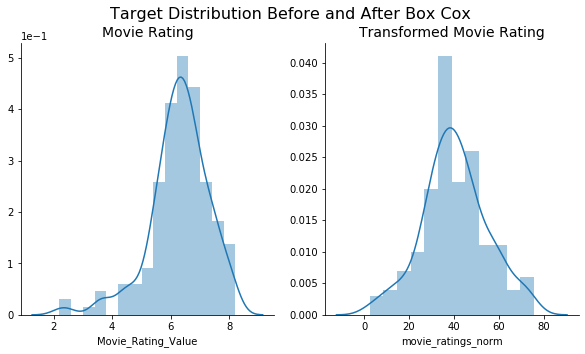

In [113]:
plt.subplots(2, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.distplot(df.Movie_Rating_Value)
plt.title('Movie Rating', size=14)
sns.despine()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.subplot(1, 2, 2)
sns.distplot(df.movie_ratings_norm)
plt.title('Transformed Movie Rating', size=14)
sns.despine()
plt.suptitle('Target Distribution Before and After Box Cox', size=16)

*** 
### Need to have intercept


In [114]:
# Add intercept column
df['intercept'] = 1

*** 
### Setting Up  For Modeling

- look at relations of raw date
- normalize features that are heavily skewed

In [115]:
raw_columns = ['Movie_Rating_Value','Movie_Rating_Count', 'Movie_Released_Year', 
             'Movie_Run_Time', 'Book_Rating_Value', 'Book_Rating_Count', 
             'Book_Publication_Year',  'Book_Length', 'Released_Year_Diff']

In [116]:
# View the correlations
df[raw_columns].corr()

,Movie_Rating_Value,Movie_Rating_Count,Movie_Released_Year,Movie_Run_Time,Book_Rating_Value,Book_Rating_Count,Book_Publication_Year,Book_Length,Released_Year_Diff
Movie_Rating_Value,1.000000,0.396866,-0.044554,0.360490,0.111263,-0.042183,-0.084782,-0.178201,0.079309
Movie_Rating_Count,0.396866,1.000000,-0.033049,0.306979,-0.103948,0.033780,-0.041791,0.010523,0.037430
Movie_Released_Year,-0.044554,-0.033049,1.000000,0.042406,0.004300,0.107356,0.168685,-0.079707,-0.021022
Movie_Run_Time,0.360490,0.306979,0.042406,1.000000,0.044757,0.010786,-0.121610,0.268758,0.129715
Book_Rating_Value,0.111263,-0.103948,0.004300,0.044757,1.000000,0.123058,-0.039025,0.068478,0.040229
Book_Rating_Count,-0.042183,0.033780,0.107356,0.010786,0.123058,1.000000,-0.047702,0.011686,0.064497
Book_Publication_Year,-0.084782,-0.041791,0.168685,-0.121610,-0.039025,-0.047702,1.000000,-0.206730,-0.988998
Book_Length,-0.178201,0.010523,-0.079707,0.268758,0.068478,0.011686,-0.206730,1.000000,0.197727
Released_Year_Diff,0.079309,0.037430,-0.021022,0.129715,0.040229,0.064497,-0.988998,0.197727,1.000000


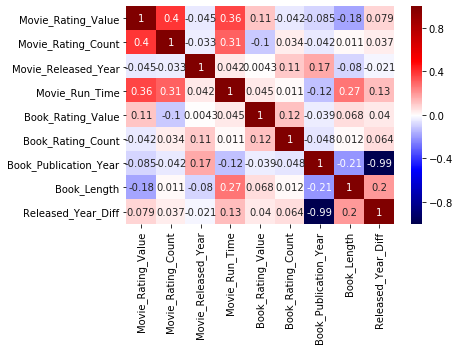

In [117]:
sns.heatmap(df[raw_columns].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

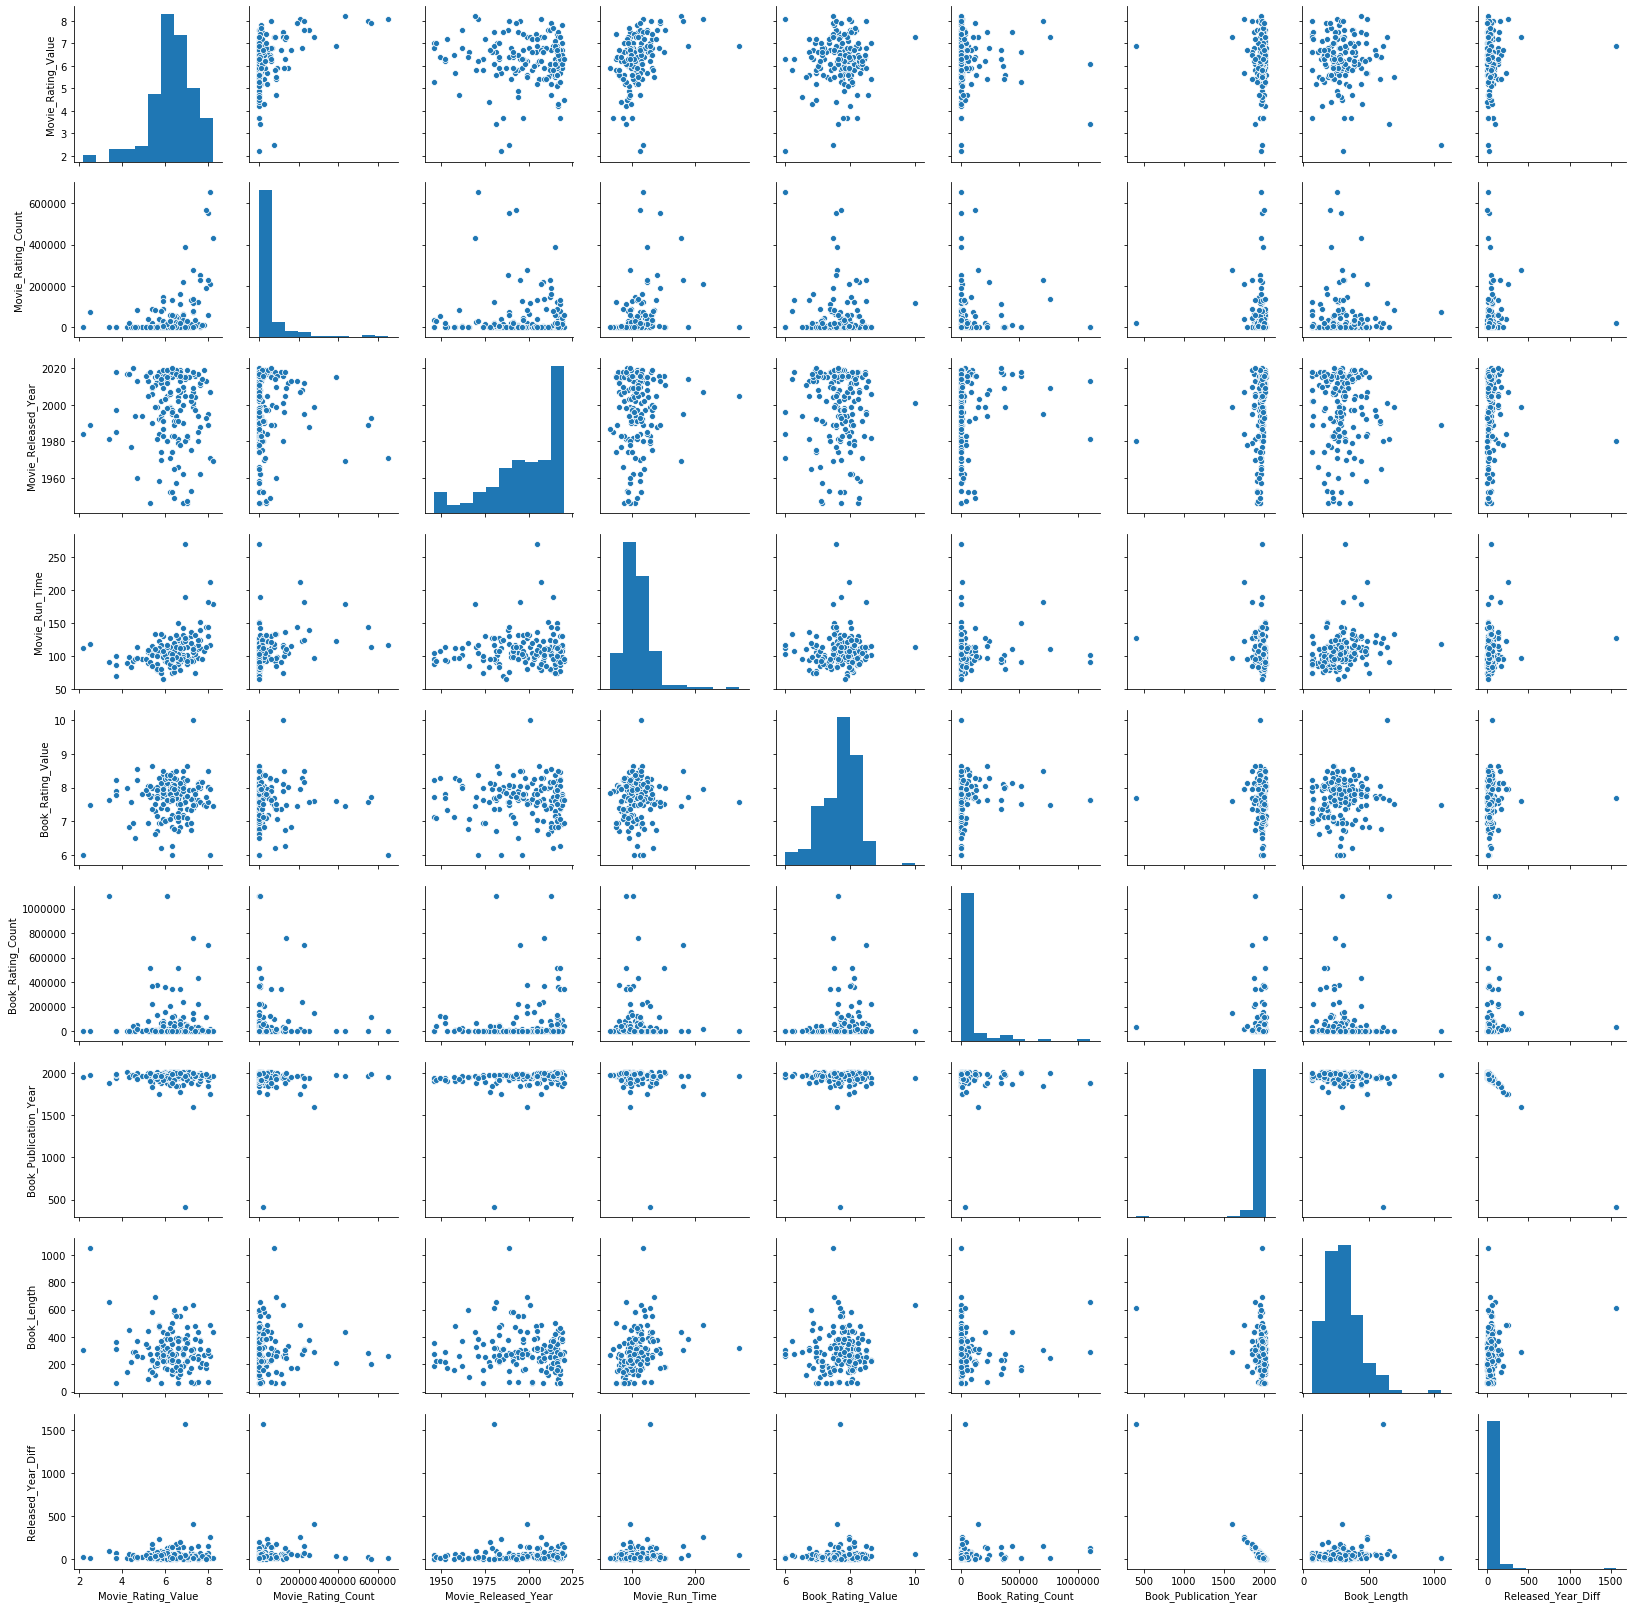

In [118]:
sns.pairplot(df[raw_columns]);

In [119]:
#Normalize those that are heavily skewed right 
df['log_Book_Rating_Count'] = np.log(df.Book_Rating_Count)
df['log_Movie_Run_Time'] = np.log(df.Movie_Run_Time) 
df['log_Movie_Release_Year'] = np.log(df.Movie_Run_Time) 
df['log_Movie_Rating_Count'] = np.log(df.Movie_Rating_Count)

In [120]:
#more normalizing for those that log wasn't enough
lamb = stats.boxcox_normmax(df.Released_Year_Diff, brack=(-5, 5))
print( "The lambda value that best normalizes the target distribution is: {:f}\n". format(lamb))
df['Box_Year_Diff'] = stats.boxcox(df.Released_Year_Diff, lamb)

The lambda value that best normalizes the target distribution is: 0.076712



In [121]:
lamb = stats.boxcox_normmax(df.Book_Publication_Year, brack=(-1, 1))
print( "The lambda value that best normalizes the target distribution is: {:f}\n". format(lamb))
df['Box_Book_Publication_Year'] = stats.boxcox(df.Book_Publication_Year, lamb)

The lambda value that best normalizes the target distribution is: 25.723961



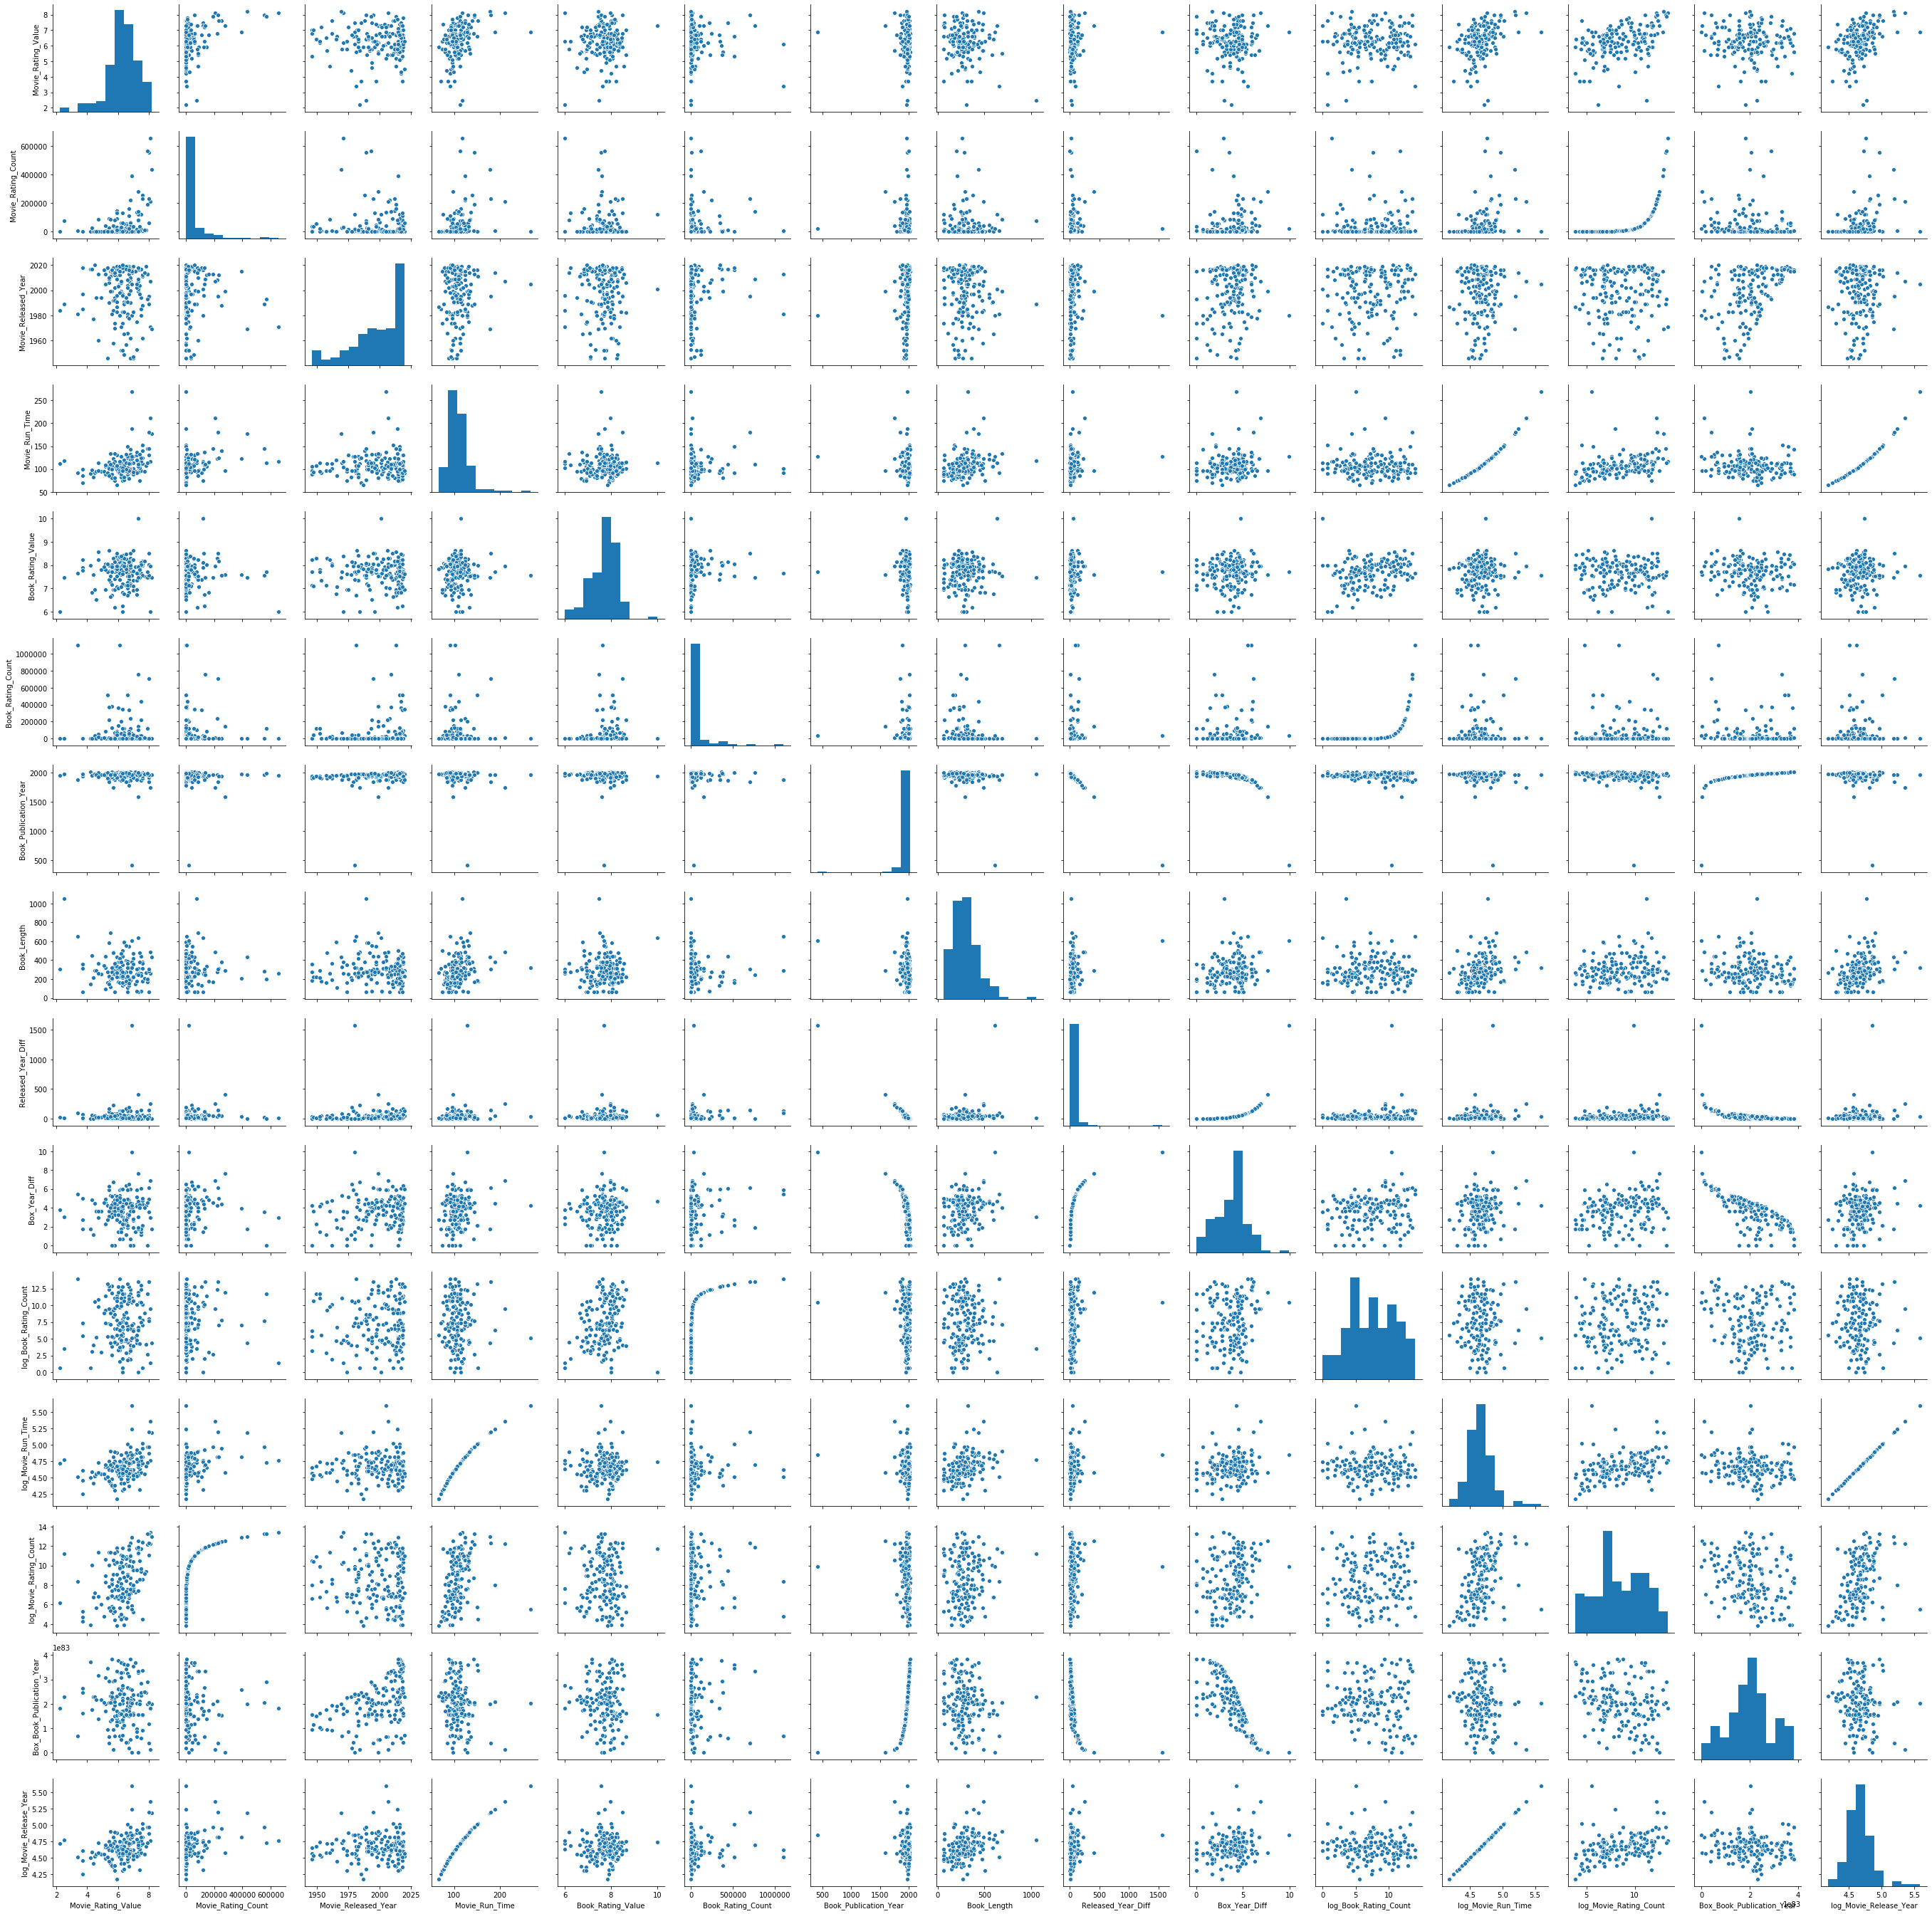

In [122]:
sns.pairplot(df[raw_columns + ['Box_Year_Diff'] + ['log_Book_Rating_Count'] + ['log_Movie_Run_Time'] + ['log_Movie_Rating_Count'] + ['Box_Book_Publication_Year'] + ['log_Movie_Release_Year']]);

In [149]:
#Sepreate features from target
x_columns = ['intercept','log_Movie_Rating_Count', 'log_Movie_Release_Year', 
             'log_Movie_Run_Time', 'Book_Rating_Value', 'log_Book_Rating_Count', 
             'Box_Book_Publication_Year',  'Book_Length', 'Box_Year_Diff']

y = df['movie_ratings_norm'] #target
X = df[x_columns]

#establish a base case for performance on the skewed target data
y_no_transform = df['Movie_Rating_Value']

In [124]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 9 columns):
intercept                    164 non-null int64
log_Movie_Rating_Count       164 non-null float64
log_Movie_Release_Year       164 non-null float64
log_Movie_Run_Time           164 non-null float64
Book_Rating_Value            164 non-null float64
log_Book_Rating_Count        164 non-null float64
Box_Book_Publication_Year    164 non-null float64
Book_Length                  164 non-null float64
Box_Year_Diff                164 non-null float64
dtypes: float64(8), int64(1)
memory usage: 11.7 KB


In [125]:
# Correlation Matrix of target and features
df[x_columns + ['movie_ratings_norm']].corr()

,intercept,log_Movie_Rating_Count,log_Movie_Release_Year,log_Movie_Run_Time,Book_Rating_Value,log_Book_Rating_Count,Box_Book_Publication_Year,Book_Length,Box_Year_Diff,movie_ratings_norm
intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_Movie_Rating_Count,NaN,1.000000,0.392720,0.392720,-0.044521,0.103662,-0.250046,0.128543,0.202638,0.446487
log_Movie_Release_Year,NaN,0.392720,1.000000,1.000000,0.052896,-0.032356,-0.146158,0.302240,0.207067,0.421691
log_Movie_Run_Time,NaN,0.392720,1.000000,1.000000,0.052896,-0.032356,-0.146158,0.302240,0.207067,0.421691
Book_Rating_Value,NaN,-0.044521,0.052896,0.052896,1.000000,0.282409,-0.067152,0.068478,0.079430,0.088468
log_Book_Rating_Count,NaN,0.103662,-0.032356,-0.032356,0.282409,1.000000,-0.099256,-0.020790,0.161606,0.031413
Box_Book_Publication_Year,NaN,-0.250046,-0.146158,-0.146158,-0.067152,-0.099256,0.000000,-0.174599,-0.729507,-0.073350
Book_Length,NaN,0.128543,0.302240,0.302240,0.068478,-0.020790,-0.174599,1.000000,0.199084,-0.136859
Box_Year_Diff,NaN,0.202638,0.207067,0.207067,0.079430,0.161606,-0.729507,0.199084,1.000000,0.008393
movie_ratings_norm,NaN,0.446487,0.421691,0.421691,0.088468,0.031413,-0.073350,-0.136859,0.008393,1.000000


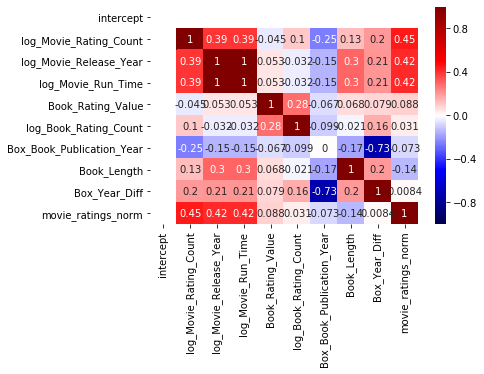

In [126]:
sns.heatmap(df[x_columns + ['movie_ratings_norm']].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

Text(0.5, 1, 'Pair Plot of Transformed Target and Feature Data')

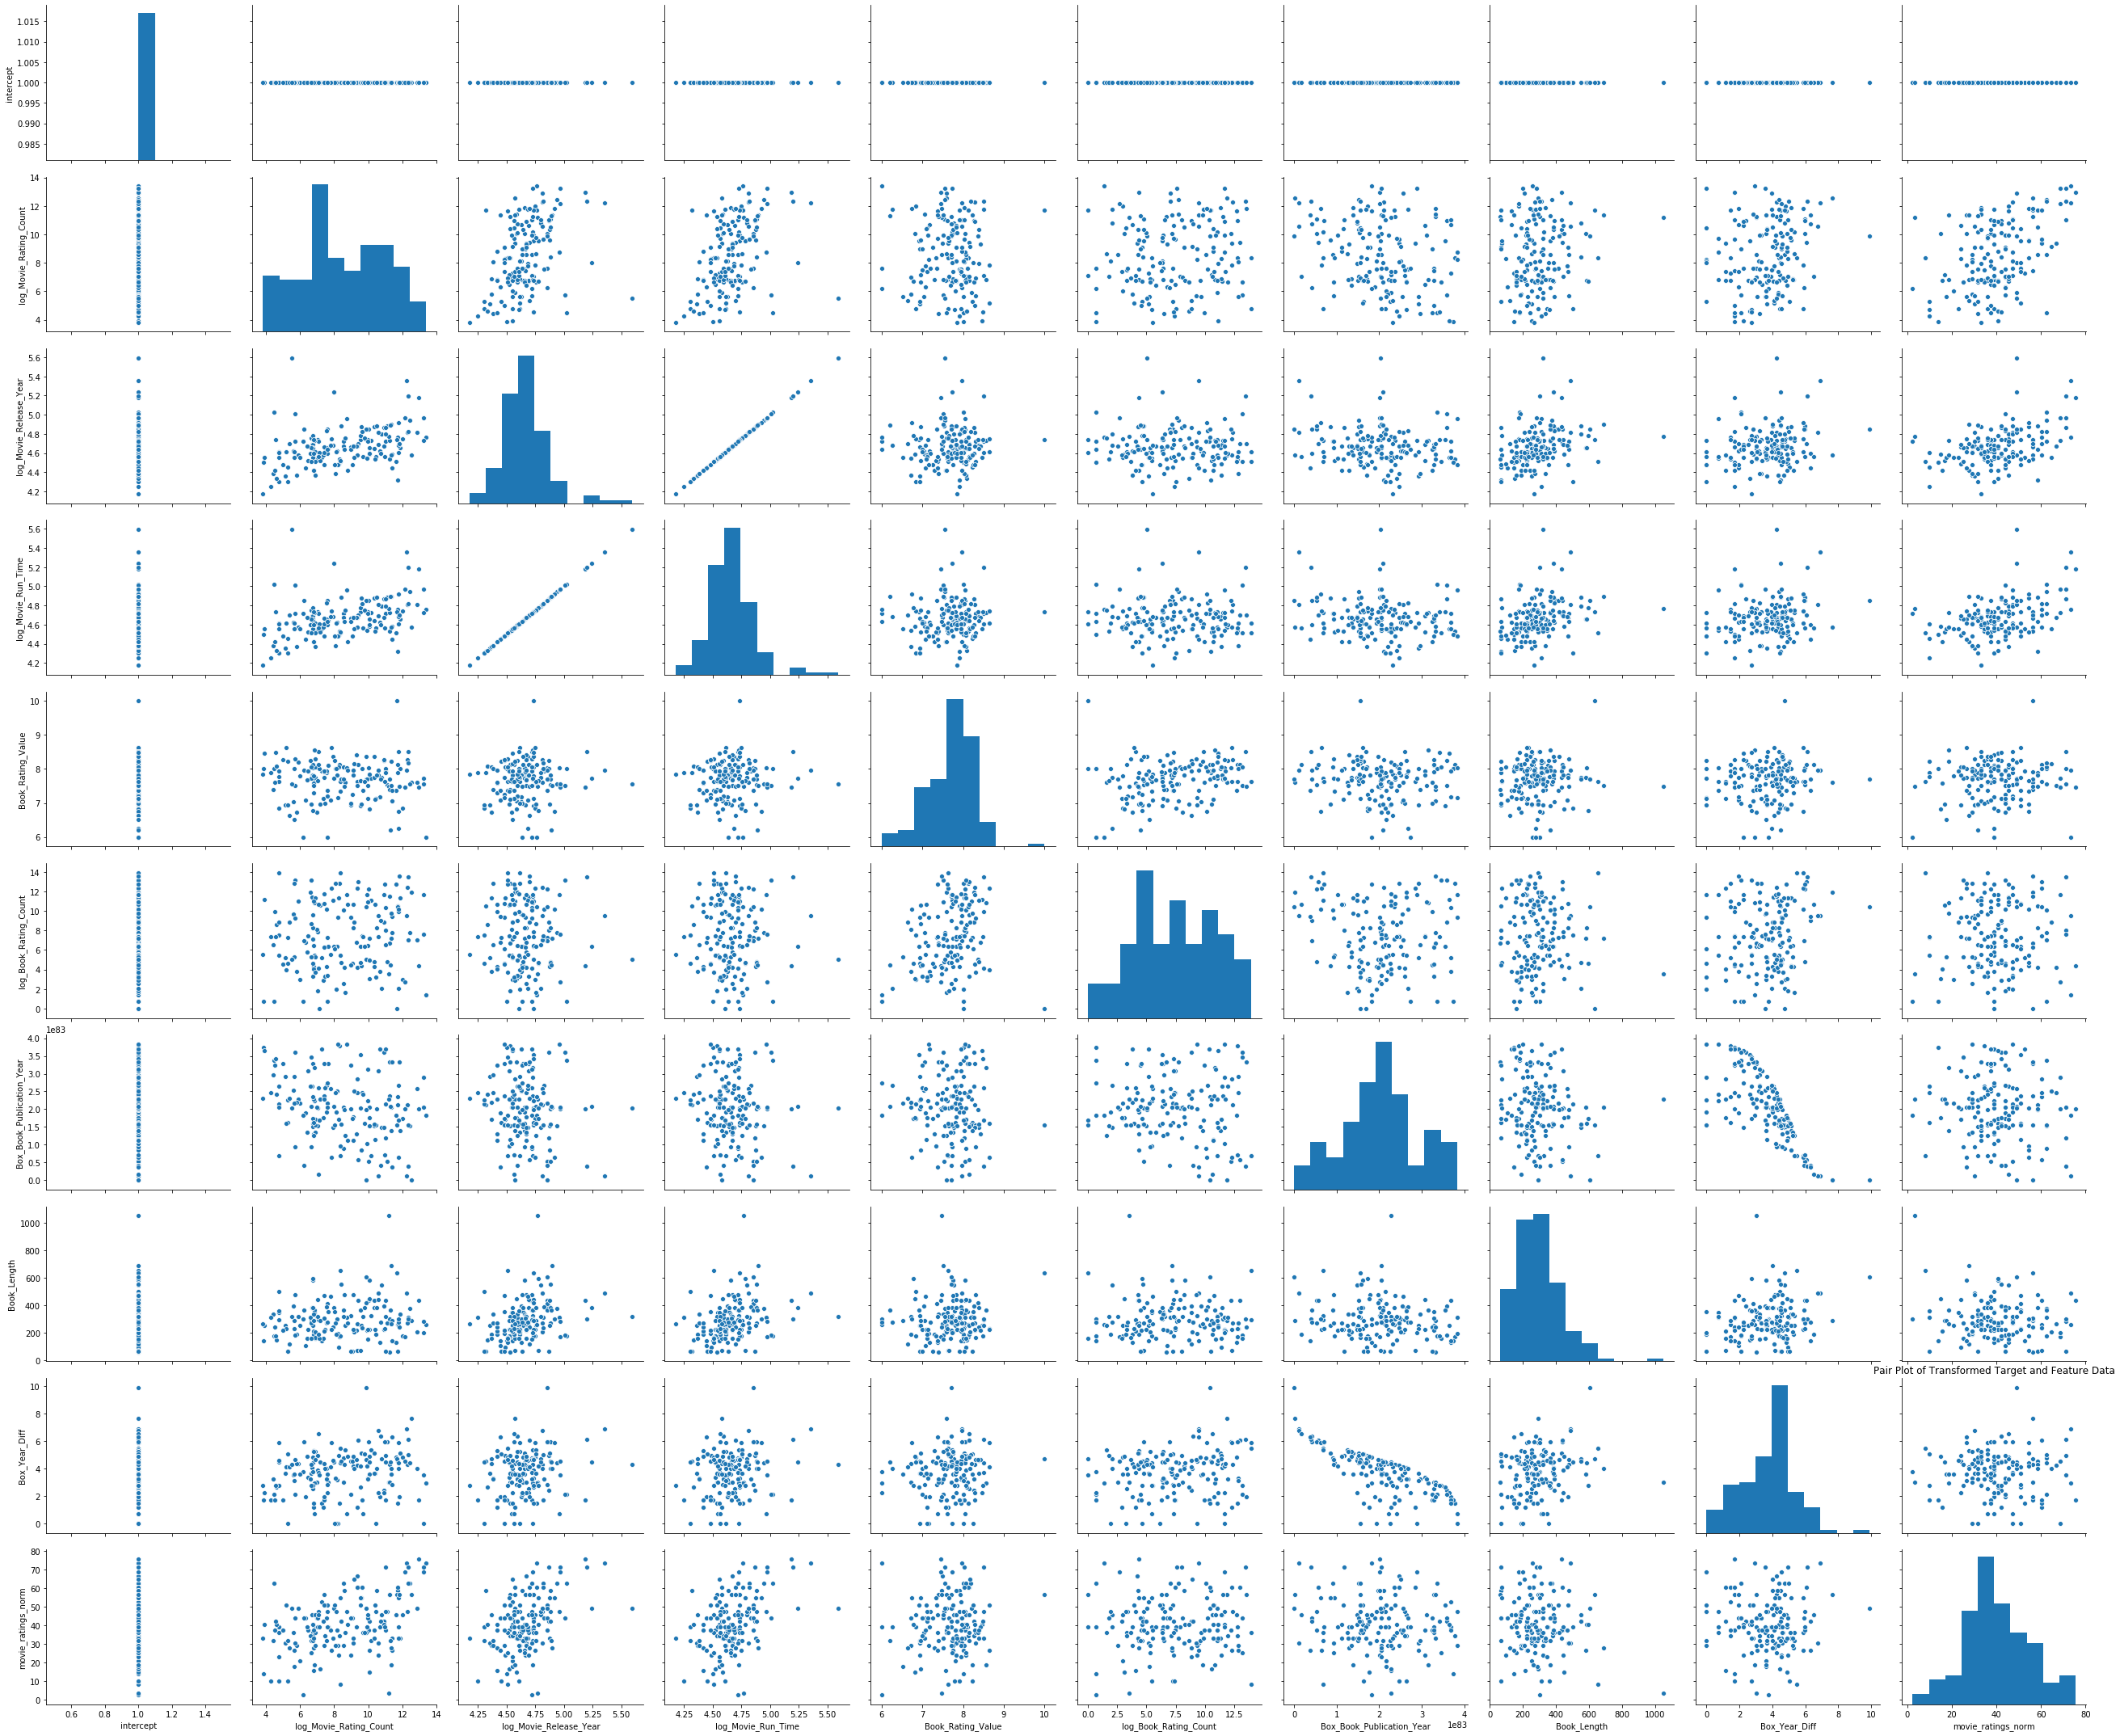

In [127]:
sns.pairplot(df[x_columns + ['movie_ratings_norm']], height=3, aspect=1.2)
plt.title('Pair Plot of Transformed Target and Feature Data')

###  Split data into training and testing sets
Train / test split with 80% to train and validate the model and 20% to test the final model

In [150]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=70)

X_train, X_val, y_train, y_val = train_test_split(X, y_no_transform, test_size=0.25, random_state=70)

### Standarize the feature data

Now we need some model setup: **when using regularization, we must standardize** the data so that all features are on the same scale (we subtract the mean of each column and divide by the standard deviation, giving us features with mean 0 and std 1). Since this scaling is part of our model, we need to scale using the training set feature distributions and apply the same scaling to validation and test without refitting the scaler. 

In [152]:
# Scale the data
scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val.values), columns= x_columns)

# Reset intercept column to a nonzero value
X_train_val_scaled['intercept'] = 1

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values), columns=x_columns)
X_test_scaled['intercept'] = 1

In [153]:
# Define splits for cross validating each model
kf = KFold(n_splits=10, shuffle=True, random_state=70)

### OLS via Statsmodel 
- start with normal OLS model
- if not happy with steps here look back at work flow
- high p-values? lasso CV
- if satisfied go to cross validation 

In [154]:
# Build a linreg model with statsmodel
lsm = sm.OLS(list(y_train_val), X_train_val_scaled)

lm_fit = lsm.fit()

lm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     9.362
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           2.88e-09
Time:                        07:38:50   Log-Likelihood:                -501.94
No. Observations:                 131   AIC:                             1020.
Df Residuals:                     123   BIC:                             1043.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    41.6718      1.007     41.398      0.000      39.679      43.664
log_Movie_Rating_Count        5.1108      1.139      4.487      0.000       2.856       7.366
log_Movie_Release_Year        2.3443      0.583      4.021      0.000       1.190       3.498
log_Movie_Run_Time            2.3443      0.583      4.021      0.000       1.190       3.498
Book_Rating_Value             2.4840      1.077      2.307      0.023       0.353       4.615
log_Book_Rating_Count        -0.1621      1.077     -0.151      0.881      -2.294       1.970
Box_Book_Publication_Year    -1.6345      1.675     -0.976      0.331      -4.950       1.681
Book_Length                  -3.7074      1.094     -3.390      0.001      -5.872      -1.543
Box_Year_Diff                -2.6708      1.662     -1.607      0.111      -5.960       0.619
==============================================================================
Omnibus:                        0.536   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.765   Jarque-Bera (JB):                0.671
Skew:                          -0.062   Prob(JB):                        0.715
Kurtosis:                       2.672   Cond. No.                     1.22e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.33e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [155]:
lm_nt = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=70)

print('Linear Regression model with target data R^2: {:f}'.format(np.mean(cross_val_score(lm_nt, X_train, y_train, cv=kf,scoring='r2'))))
lm_nt.fit(X_train, y_train)

Linear Regression model with target data R^2: -0.200820


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [156]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [157]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

##### Lasso 

In [184]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [185]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.1011637979766207

In [198]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X.columns, lasso_model.coef_))

[('intercept', 0.0),
 ('log_Movie_Rating_Count', 0.1887512614682431),
 ('log_Movie_Release_Year', 0.171421048584554),
 ('log_Movie_Run_Time', 7.220962761789636e-17),
 ('Book_Rating_Value', 0.07986955476957835),
 ('log_Book_Rating_Count', 0.0),
 ('Box_Book_Publication_Year', 0.0),
 ('Book_Length', -0.1173587569530321),
 ('Box_Year_Diff', -0.0)]

In [200]:
log_Movie_Release_Year_coef = lm_nt[2]
log_Movie_Release_Year_std = np.std(X_train_val['log_Movie_Release_Year'])
print(
    "For every additional additional view on a Channel's latest video,\n\
there will be an increase in views on the next video of {:f}"
    .format(
        scipy.special.boxcox(np.exp(log_Movie_Release_Year_coef / log_Movie_Release_Year_std),
                             lamb)))

TypeError: 'LinearRegression' object is not subscriptable

In [187]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [188]:
# Find the MAE and R^2 on the test set using this model
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

29.52746489751512

In [189]:
r2_score(y_test, test_set_pred)

-3.449699175585419

In [190]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, cv=5,scoring='r2') 

array([-0.04048422, -0.00637381, -0.05702928, -0.05604719, -0.05728729])

In [194]:
kf = KFold(n_splits=10, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([-0.07112738, -0.21513829, -0.01206726, -0.0400385 , -0.08487524,
       -0.03186587, -0.00657982, -0.01636733, -0.00764908, -0.25349422])

##### Ridge 
- gave better result than lasso 

In [204]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.408


In [208]:
y_pred = lm_reg.predict(X_test_scaled)

should I unscale (un-boxcox) to get a error that relate to the rating values? 

In [241]:
mae(y_test, y_pred)

10.372313473477485

In [215]:
resid = y_test - y_pred

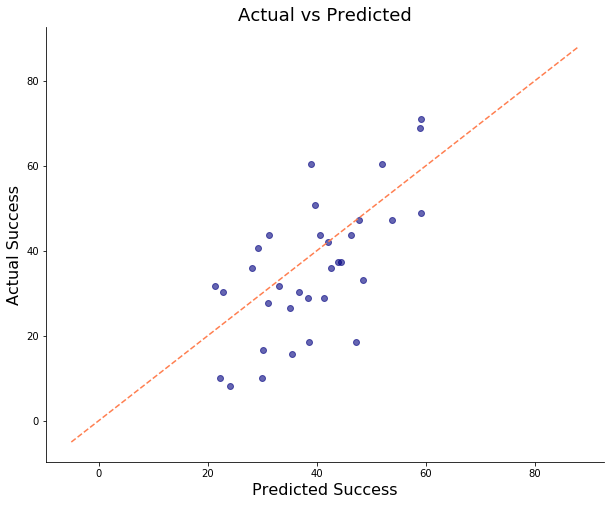

In [242]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([-5, 88], [-5, 88], '--', c='coral')
plt.scatter(y_pred, y_test, color='navy', alpha=0.6)
plt.xlabel('Predicted Success')
plt.ylabel('Actual Success')
sns.despine()
plt.ylabel('Actual Success', size=16)
plt.xlabel('Predicted Success', size=16)
plt.title('Actual vs Predicted', size=18)
plt.savefig('actual_vs_predicted.png', transparent=True)

In [202]:
print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

-0.07392030010137599
0.24710355586696262


/Users/sammy/miniconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.29037e-169): result may not be accurate.
  overwrite_a=True).T
/Users/sammy/miniconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.46089e-169): result may not be accurate.
  overwrite_a=True).T
/Users/sammy/miniconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.45324e-169): result may not be accurate.
  overwrite_a=True).T
/Users/sammy/miniconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.55363e-169): result may not be accurate.
  overwrite_a=True).T
/Users/sammy/miniconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.51414e-169): result may

### Looking at data not yet transformed

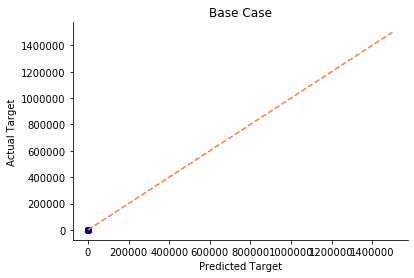

In [221]:
plt.scatter(test_set_pred, y_test, color='navy')
sns.despine()
plt.xlabel('Predicted Target')
plt.ylabel('Actual Target')
plt.title('Base Case')
plt.plot([0, 1500000], [0, 1500000], '--', color='coral')

Text(0.5, 1.0, '')

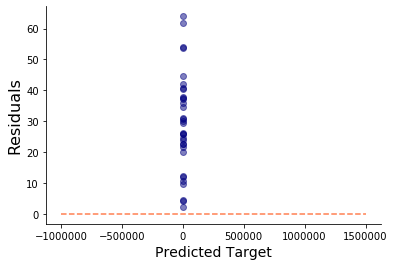

In [222]:
# Plot residuals vs predicted target values
plt.figure(figsize=(6, 4))
plt.scatter(test_set_pred, y_test - test_set_pred, alpha=0.5, color='navy')
plt.xlabel('Predicted Target', size=14)
sns.despine()
plt.ylabel('Residuals', size=16)
plt.plot([-1000000, 1500000], [0, 0], '--', color='coral')
plt.title('')
#plt.savefig('img/resid_pred_untransform.png')

Observing the use of the features 

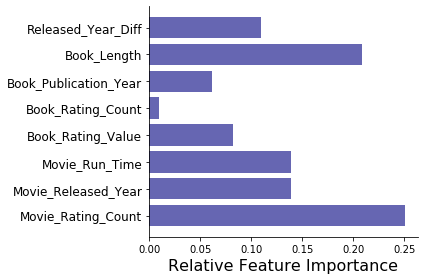

In [233]:
fig, ax = plt.subplots()
plt.barh(np.arange(len(lm_reg.coef_) - 1),
         np.abs(lm_reg.coef_[1:]) / sum(np.abs(lm_reg.coef_[1:])), alpha=0.6, color='navy')
ax.set_yticks(np.arange(len(lm_reg.coef_) - 1))
plt.xlabel('Relative Feature Importance', size=16)
sns.despine()
ax.set_yticklabels([
       'Movie_Rating_Count', 'Movie_Released_Year',
        'Movie_Run_Time', 'Book_Rating_Value', 'Book_Rating_Count',
       'Book_Publication_Year', 'Book_Length', 'Released_Year_Diff'],size=12)
plt.tight_layout()
plt.savefig('features.png', transparent=True)